## Run the program and collect outputs

In [1]:
algos = {
    "c++11": ("./main", ["qsort", "stdsort", "qsort-baseline"]),
    "java8": ("java Main", ["arrays-sort"]),
    "python3": ("python3 main.py", ["sorted"])
}

interval = "100000"
max_n    = "10000000"

In [2]:
!java -version

openjdk version "1.8.0_212"
OpenJDK Runtime Environment (AdoptOpenJDK)(build 1.8.0_212-b03)
OpenJDK 64-Bit Server VM (AdoptOpenJDK)(build 25.212-b03, mixed mode)


In [3]:
!g++ --version

Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/4.2.1
Apple clang version 11.0.0 (clang-1100.0.33.8)
Target: x86_64-apple-darwin19.0.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


In [4]:
!make
!javac Main.java

make: `main' is up to date.


In [5]:
xyss = {}
for algo in algos:
    xyss[algo] = {}
    cmd, subalgos = algos[algo]
    for subalgo in subalgos:
        output = !$cmd $subalgo $interval $max_n
        xys = [tuple(l.split()) for l in output ]
        xs = [float(x) for x, _ in xys]
        ys = [float(y) for _, y in xys]
        xyss[algo][subalgo] = (xs, ys)

## Plot time spent for different sizes of input

In [6]:
import matplotlib.pyplot as plt

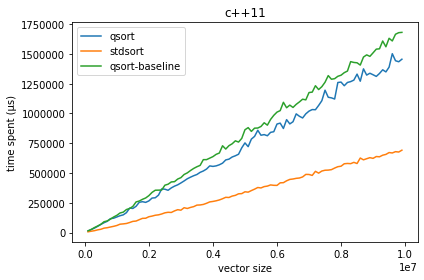

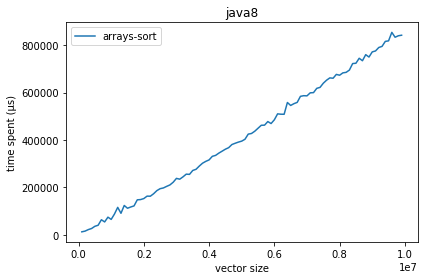

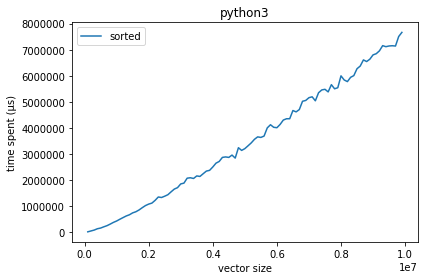

<Figure size 432x288 with 0 Axes>

In [7]:
for algo, subalgos in xyss.items():
    plt.title(algo)
    plt.xlabel("vector size")
    plt.ylabel("time spent (μs)")
    for subalgo, xys in subalgos.items():
        xs, ys = xys
        plt.plot(xs, ys, label=subalgo)
    plt.legend()
    plt.tight_layout()
    plt.savefig(algo + ".png")
    plt.show()
    plt.clf()